### Imports

In [1]:
import numpy as np
import pandas as pd 
from collections import Counter
import os
import glob
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import scipy.stats as stats
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

### Read every cohort study file

In [2]:
datasets = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../cohort_studies_full_data/' + "/*."+'csv'))]
cohorts = [file.split(".")[0] for file in sorted(os.listdir('../cohort_studies_full_data/'))]

In [3]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies = dict()
# dfsss = dict()

for cohort, dataset in zip(cohorts, datasets):
    cohort_n = cohort.split("_MERGE")[0]
    cohort_studies[cohort_n] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit
#     dfsss[cohort_n] = dataset

In [4]:
datasets_sub = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../preprocessed_datasets/' + "/*."+'csv'))]
cohorts_sub = [file.split(".")[0] for file in sorted(os.listdir('../preprocessed_datasets/'))]

In [5]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies_sub = dict()

for cohort, dataset in zip(cohorts_sub, datasets_sub):
    cohort_studies_sub[cohort] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit

In [6]:
# add the preprocessed columns from sub table of each dataset to the main table of dataset
for i in cohort_studies:
#     cols = cohort_studies_sub[i].columns.difference(cohort_studies[i].columns)
    cols = ['Age', 'Sex', 'Education', 'APOE4', 'CDR', 'Race']
    
    for col in cols:
        
        if col in cohort_studies_sub[i].columns:
            cohort_studies[i][col] = cohort_studies_sub[i][col]

### Read harmonized mapping tables

In [7]:
modality = [pd.read_csv(file, sep=',') for file in sorted(glob.glob('../feature_tables' + "/*."+'csv'))]
name = [file.split(".")[0] for file in sorted(os.listdir('../feature_tables'))]

In [8]:
# make a dictionary that contains all modalities as a dataframe
mappings = dict()

for moda, na in zip(modality, name):
    mappings[na.split(' - ')[1]] = moda

In [9]:
harmonized_features = pd.concat(mappings, ignore_index=True) # combine all tables

In [10]:
# exclude categorical and taboo features
harmonized_features = harmonized_features.loc[(harmonized_features['Rank']!=1) & (harmonized_features['Rank']!=2)]

### Read the feature availability files for all cohorts

In [11]:
ava_mapp = [pd.read_csv(file, sep='\t') for file in sorted(glob.glob('../feature_availability_in_cohorts' + "/*."+'tsv'))]
tablesss = [file.split(".")[0] for file in sorted(os.listdir('../feature_availability_in_cohorts'))]

In [12]:
# make a dictionary that contains all modalities as a dataframe
available_features = dict()

for modal, df in zip(tablesss, ava_mapp):
    available_features[modal] = df

In [13]:
existing_features = pd.concat(available_features, ignore_index=True) # combine all tables

In [14]:
existing_features.replace({0: np.nan}, inplace=True) # 0 indicates that the feature was not measured 

### Read cutoffs obtained using all methods

In [15]:
table_method = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../results/cutoffs/' + "/*."+'csv'))]
method_name = [file.split(".")[0] for file in sorted(os.listdir('../results/cutoffs/'))]

In [16]:
# make a dictionary that contains each cutoff table as a dataframe
cutoffs_ = dict()

for tm, mn in zip(table_method, method_name):
    cutoffs_[mn] = tm

In [17]:
[cutoffs_['km_cutoffs'].rename(columns={col: col.split('_')[0]}, inplace=True) for col in cutoffs_['km_cutoffs'].columns]

[None, None, None]

### Selecetion of cohort studies for A/T/N assignment

### Select the patient that have CSF biomarker, disregard the diagnostic status

In [18]:
atn = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=mappings['csf'].Feature.loc[0:2].to_list()+(["Total"]))
# atn = pd.DataFrame(index=cohort_studies, columns=['A', 'T', 'N'])

In [19]:
for cohort in atn.index:
    for feat in mappings['csf'][cohort].loc[0:2].dropna().to_list():
        if feat in cohort_studies[cohort].columns:
            atn.loc[cohort, mappings['csf'].loc[mappings['csf'][cohort]==feat, 'Feature']] = len(cohort_studies[cohort][feat].dropna())
            atn.loc[cohort, 'Total'] = len(cohort_studies[cohort][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

In [20]:
# atn

In [21]:
diag = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=cohort_studies['ADNI']['Diagnosis'].dropna().unique())

In [22]:
for cohort in diag.index:
    for dia in diag.columns:
        diag.loc[cohort, dia] = len(cohort_studies[cohort].loc[cohort_studies[cohort]['Diagnosis']==dia][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

### Remove the empty columns from all cohorts that we are intrested in
### Remove the participant without all 3 CSF biomarkers

In [23]:
selected_cohorts = dict()

for coh in diag.index:
    selected_cohorts[coh] = cohort_studies[coh].dropna(axis=1, how='all')

In [24]:
total_feats = dict()

# existing_features.set_index('Feature', inplace=True)

for feat in existing_features.Feature:
    total_feats[feat] = existing_features.loc[existing_features.Feature==feat][selected_cohorts].dropna(axis=1).columns

In [25]:
for cohort in atn.index:
    feat = mappings['csf'][cohort].loc[0:2].dropna().to_list()
    cohort_studies[cohort] = cohort_studies[cohort].dropna(subset=feat)

As Some features have suffix due to merging tables for certain cohorts, first investigate if all the harmonized features are in cohorts. Rename the ones that have suffix so it can be compatible to work with our harmonized names.

In [26]:
cohort_studies['ADNI'].rename(columns={'PTEDUCAT_x': 'PTEDUCAT', 'TRABSCOR_bl': 'TRABSCOR', 'LDELTOTAL_BL': 'LDELTOTAL'}, inplace=True)

### CSF biomarkers, two classes, normal vs abnormal

In [27]:
# cohorts_csf = dict()

# for i in atn.index:
    
#     csf = mappings['csf'].iloc[:3][i].to_list()
#     cohorts_csf[i] = cohort_studies[i][csf + ["Diagnosis", "Age"]]
#     cohorts_csf[i] = cohorts_csf[i].dropna(subset=cohorts_csf[i].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)
       
#     #     for col in ['A', 'T', 'N']:
#     #         cohorts_csf[i][col]=np.nan

In [28]:
# td = pd.concat(mappings, ignore_index=True)
# td.loc
# td.loc[td['Rank']== 1]['Feature']

In [29]:
# modality_ = ['clinical_i', 'clinical_ii','hippocampus', 'csf']
modality_ = ['basal_ganglia', 'brain_poles_volume', 'cerebellum', 'clinical_i', 
            'clinical_ii', 'csf', 'diencephalus', 'general_brain', 
            'mri_others', 'pet', 'plasma', 'ventricles', 'hippocampus']

selected_feat = dict()

for i in modality_:
    selected_feat[i] = mappings[i]

In [30]:
# make a dataframe containing all the mapped features
features_all = pd.concat(selected_feat, ignore_index=True)

In [31]:
features_all = features_all[atn.index.union(['Feature', 'Rank'])] # subset the cohorts of interest

In [32]:
# remove the features that are not available in all studies
features_all = features_all.loc[features_all['Feature'].isin(existing_features[atn.index.union(['Feature'])].dropna(how='all')['Feature'].to_list())]

* Rank 1 --> Categorical features
* Rank 2 --> Taboo features: some categorical and some numerical
* Rank nan --> Numerical features 

replace nan with 0

In [33]:
features_all['Rank'].replace({np.nan: 0}, inplace=True)

## Prepare datasets

In [34]:
def umap_atn_participants(dfss, cohorts, thresholds, features):
    """cohorts: list of cohort names 
       dfss: dictionary of cohorts where each key is the name of a cohort
       thresholds: cutoff values obtained using a methodology
        
    """
    # make a list of additional features to be investigated 
    additional_feat = ['Age', 'Sex', 'Education', 'APOE4', 'CDR', 'Race']
    # make an empty dictionary to add the datasets to
    df_= pd.DataFrame(columns=set(features.loc[features['Rank']==0]
                                  [cohorts + ['Feature']].dropna()['Feature']).difference(['Feature'] + list(thresholds.columns)).union(additional_feat))
   
    for i in cohorts:
        dfs = dict()
        dfs[i] = dfss[i].copy() # make a copy of the dataset of interest
        # select the subset of datasets with features to be investigated
        dfs[i] = dfs[i][features.loc[features['Rank']==0][cohorts + ['Feature']].dropna()[i].to_list() + additional_feat].dropna(axis=1, how='all')
        # rename all the columns so we can concat the datasets later
        [dfs[i].rename(columns={col: coln}, inplace=True) for col, coln in 
         zip(features.loc[features['Rank']==0][cohorts + ['Feature']].dropna()[i].to_list(), 
             features.loc[features['Rank']==0][cohorts + ['Feature']].dropna()['Feature'].to_list())]
        dfs[i]['Cohort'] = i # add a cohort name column
        # change the datatype to str as these are categorical features. astype doesn't work as it will include nan values
        dfs[i] = dfs[i].replace({'CDR': {0.0: '0', 0.5: '0.5', 1.0: '1', 2.0: '2'}, 
                                               'APOE4': {0.0: '0', 2.0: '2', 1.0: '1'}}) 
        
        for biomarker in thresholds.columns:
            # select the cutoff value for each biomarker for each cohort
            threshold = thresholds.loc[i][biomarker]
            
            # dichotomize the participants
            if biomarker == 'pTau in CSF': 
                dfs[i].loc[dfs[i][biomarker]>threshold, "T"] = 'T+'
                dfs[i].loc[dfs[i][biomarker]<threshold, "T"] = 'T-'
            
            elif biomarker == 'tTau in CSF': 
                dfs[i].loc[dfs[i][biomarker]>threshold, "N"] = 'N+'
                dfs[i].loc[dfs[i][biomarker]<threshold, "N"] = 'N-'
                
            else: 
                dfs[i].loc[dfs[i][biomarker]<threshold, "A"] = 'A+'
                dfs[i].loc[dfs[i][biomarker]>threshold, "A"] = 'A-'
                
        # join the 3 columns to make the final ATN categorie                                 
        dfs[i]['ATN'] = dfs[i]['A'] + dfs[i]['T'] + dfs[i]['N']
        # remove the columns that we are not interested in
        dfs[i] = dfs[i][dfs[i].columns.difference(['A', 'T', 'N'] + list(thresholds.columns))]
        
        df_ = pd.concat([df_, dfs[i]])
    
    df_ = df_.dropna(axis=1, how='all')
    df_ = df_.dropna()

    return df_

In [35]:
def norm_df(df, cohorts_l):
    """"""
    cohort_dict = dict()
    for i in cohorts_l:
        sub_df = df.loc[df['Cohort']==i]
        # make dummy variables and normalize features 
        num = sub_df[sub_df.select_dtypes(exclude='object').columns.difference(['APOE4', 'CDR'])].apply(stats.zscore)
        cat = pd.get_dummies(sub_df[sub_df.select_dtypes(include='object').columns.difference(['ATN', 'Cohort'])].dropna())
        others = sub_df[['ATN', 'Cohort']]
        data_f = pd.concat([num, cat, others], axis=1)
        cohort_dict[i] = data_f
    return cohort_dict

In [36]:
def cohorts_vs_method(cohortsss):
    """"""
    
    result_dfs = dict()
    for method in set(cutoffs_.keys()).difference(["cutoffs_cohort_study"]):
        umap_df = umap_atn_participants(cohort_studies, cohortsss, cutoffs_[method], features_all)
        umap_df_concat = pd.concat(norm_df(umap_df, cohortsss), ignore_index=True)
        
        for i, j in zip(cohortsss, list(range(len(cohortsss)))):
            umap_df_concat.replace({i: j}, inplace=True)
        
        atn_parti = Counter(umap_df_concat['ATN'])
        remove_atn = list()

        for i in atn_parti:

            if atn_parti[i] < 25:
                remove_atn.append(i)

        for atn_r in remove_atn:
            umap_df_concat = umap_df_concat.loc[umap_df_concat['ATN']!=atn_r]
        
        result_dfs[method] = umap_df_concat.dropna(axis=1)
        
    return result_dfs

In [37]:
adni_epad = cohorts_vs_method(['ADNI', 'EPAD'])

In [47]:
def plot_result(dfs_dict, list_cohort):
    """"""
    if len(list_cohort) < 3:
        title_cohs = ' and '.join([str(item) for item in list_cohort])
            
    else:
        title_cohs = ', '.join([str(item) for item in list_cohort[:-1]]) + ' and ' + list_cohort[-1]
    
    
    for met in dfs_dict:
        df = dfs_dict[met]
        fig, axes = plt.subplots(len(df['ATN'].unique()), figsize=(6, 3 * len(df['ATN'].unique())))
        
        patches = list()
        colors = np.array(['#d62728', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', '#ffbb78', '#98df8a', 
                  '#ff9896', '#c49c94', '#c7c7c7'])
        
        for n in list_cohort:
            patches.append(Line2D([0], [0], color='w', marker='o', markerfacecolor=colors[list_cohort.index(n)], label=n))

        for atn_, ind in zip(df['ATN'].unique(), range(len(df['ATN'].unique()))):
            embedding = umap.UMAP(n_neighbors=5).fit_transform(df.loc[df['ATN']==atn_][df.columns.difference(['Cohort', 'ATN'])], 
                    y=df.loc[df['ATN']==atn_]['Cohort'])
            
            plt.legend(handles=patches)

            scatter = axes[ind].scatter(*embedding.T, s=4, c=colors[df.loc[df['ATN']==atn_]['Cohort']], cmap='Spectral', alpha=1.0, label=list_cohort)
            plt.setp(axes[ind], xticks=[], yticks=[])
                     
            axes[ind].set_title(f'Comparison of participants in {atn_} categorie', fontsize=10)
            fig.suptitle(f'ATN based comparision among {title_cohs} cohorts')
            fig.subplots_adjust(top=0.95, wspace=0.5)
#             plt.savefig(f"../results/umap/{met}.png", dpi=300, bbox_inches='tight')

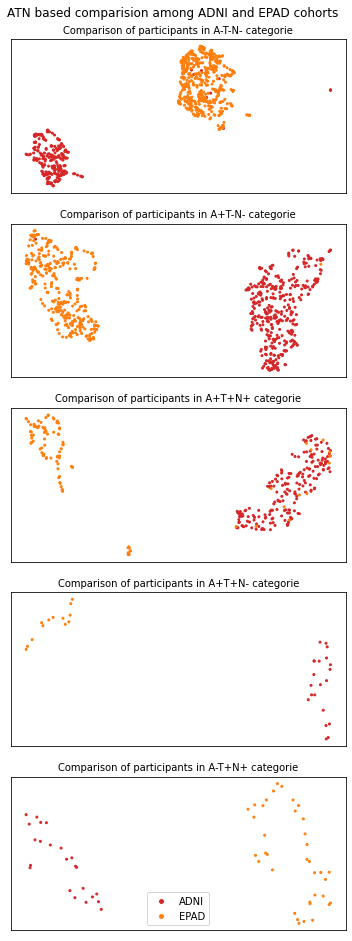

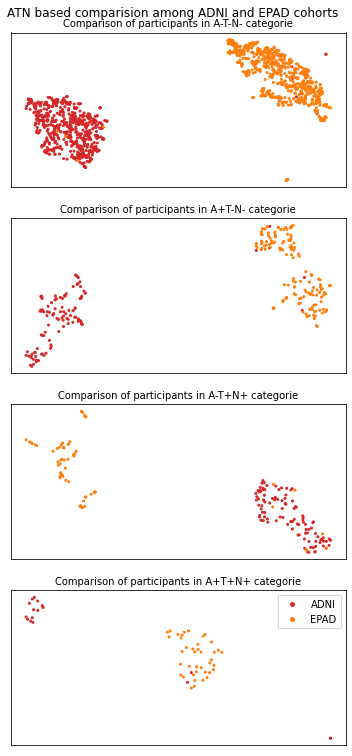

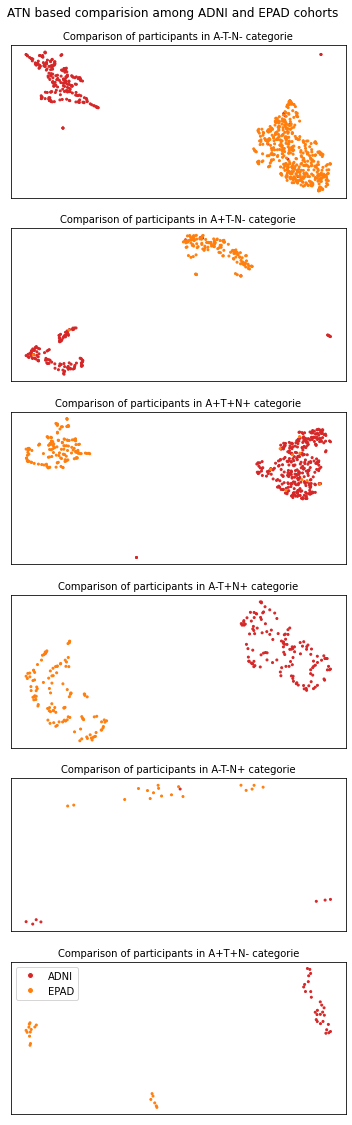

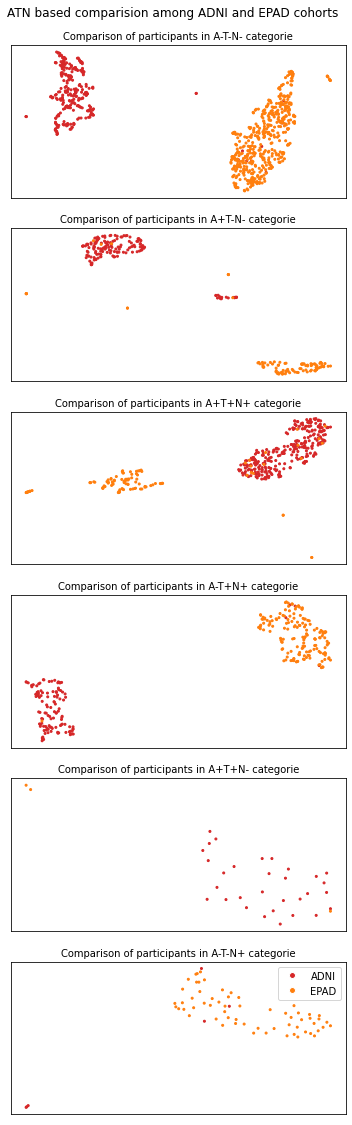

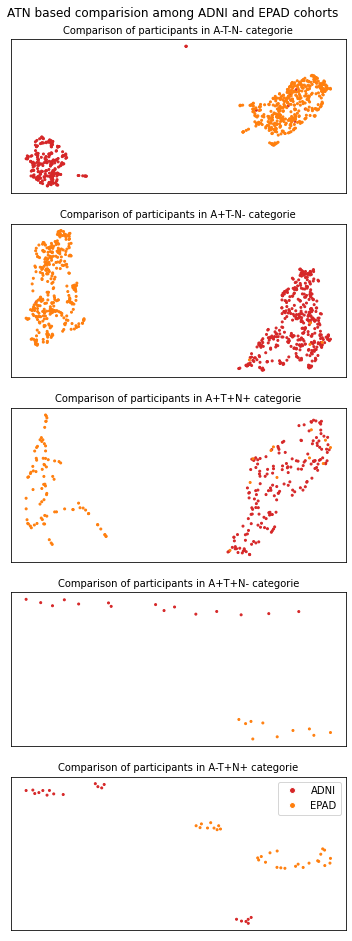

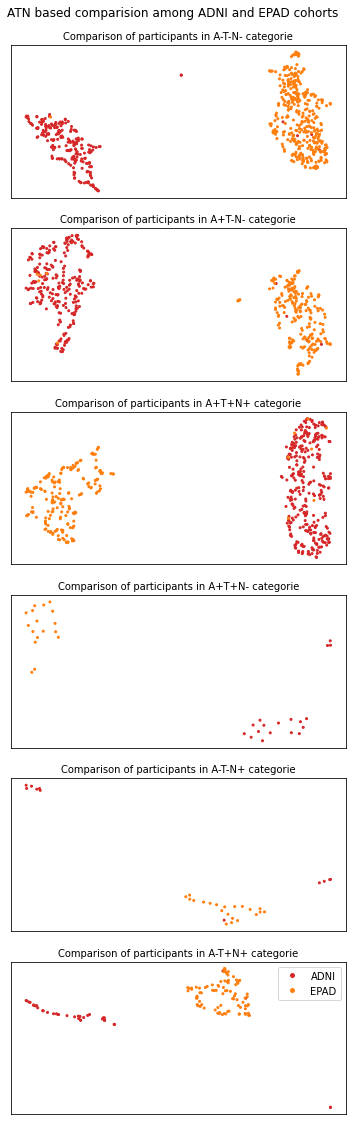

In [48]:
plot_result(adni_epad, ['ADNI', 'EPAD'])

In [ ]:
# umap_adni_epad = umap_atn_participants(cohort_studies, ['ADNI', 'EPAD'], cutoffs_['tertile_cutoffs'], features_all)

In [ ]:
# result_adni_epad = pd.concat(norm_df(umap_adni_epad, ['ADNI', 'EPAD']), ignore_index=True)
# result_adni_epad.dropna(axis=1, inplace=True)
# result_adni_epad.replace({'ADNI': 1, 'EPAD': 2}, inplace=True)

# atn_parti = Counter(result_adni_epad['ATN'])
# remove_atn = list()

# for i in atn_parti:
    
#     if atn_parti[i] < 25:
#         remove_atn.append(i)
        
# for atn_r in remove_atn:
#     result_adni_epad = result_adni_epad.loc[result_adni_epad['ATN']!=atn_r]

In [ ]:
# fig, axes = plt.subplots(len(result_adni_epad['ATN'].unique()), figsize=(10, 20))

# for atn_, ind in zip(result_adni_epad['ATN'].unique(), range(len(result_adni_epad['ATN'].unique()))):
# #     num_subfig = len(tttt['ATN'].unique())

#     embedding = umap.UMAP(n_neighbors=5).fit_transform(result_adni_epad.loc[
#         result_adni_epad['ATN']==atn_][result_adni_epad.columns.difference(['Cohort', 'ATN'])], 
#             y=result_adni_epad.loc[result_adni_epad['ATN']==atn_]['Cohort'])
    
#     axes[ind].scatter(*embedding.T, s=1, c=result_adni_epad.loc[result_adni_epad['ATN']==atn_]['Cohort'], cmap='Spectral', alpha=1.0)
#     plt.setp(axes[ind], xticks=[], yticks=[])
# #     cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
# #     cbar.set_ticks(np.arange(10))
#     # cbar.set_ticklabels(classes)
#     plt.title('');

In [ ]:
# def plot_result(dfs_dict, list_cohort):
#     """"""
#     if len(list_cohort) < 3:
#         title_cohs = ' and '.join([str(item) for item in list_cohort])
            
#     else:
#         title_cohs = ', '.join([str(item) for item in list_cohort[:-1]]) + ' and ' + list_cohort[-1]
    
    
#     for met in dfs_dict:
#         df = dfs_dict[met]
#         fig, axes = plt.subplots(len(df['ATN'].unique()), figsize=(6, 3 * len(df['ATN'].unique())))
        
#         patches = list()
#         colors = np.array(['#d62728', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', '#ffbb78', '#98df8a', 
#                   '#ff9896', '#c49c94', '#c7c7c7'])
        
#         for n in list_cohort:
#             patches.append(Line2D([0], [0], color='w', marker='o', markerfacecolor=colors[list_cohort.index(n)], label=n))

#         for atn_, ind in zip(df['ATN'].unique(), range(len(df['ATN'].unique()))):
#             embedding = umap.UMAP(n_neighbors=5).fit_transform(df.loc[df['ATN']==atn_][df.columns.difference(['Cohort', 'ATN'])], 
#                     y=df.loc[df['ATN']==atn_]['Cohort'])
            
# #             color_ = np.array(['black', 'green'])
# #             patch_1 = Line2D([0], [0], color='w', marker='o', markerfacecolor=color_[0], label=list_cohort[0])
# #             patch_2 = Line2D([0], [0], color='w', marker='o', markerfacecolor=color_[1], label=list_cohort[1])
#             plt.legend(handles=patches)

#             scatter = axes[ind].scatter(*embedding.T, s=4, c=colors[df.loc[df['ATN']==atn_]['Cohort']], cmap='Spectral', alpha=1.0, label=list_cohort)
#             plt.setp(axes[ind], xticks=[], yticks=[])
                     
# #             axes[len(df['ATN'].unique())-1].legend(*scatter.legend_elements())           
#             axes[ind].set_title(f'Comparison of participants in {atn_} categorie', fontsize=10)
#             fig.suptitle(f'ATN based comparision among {title_cohs} cohorts')
#             fig.subplots_adjust(top=0.95, wspace=0.5)
# #             plt.savefig(f"../results/umap/{met}.png", dpi=300, bbox_inches='tight')